In [14]:
import itertools
import json
from pprint import pprint

import clip  # type: ignore
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import spearmanr, pearsonr

from datasets import AttributeDataset, ImageDataset, TextDataset, create_dataloader
from models import Linear
from trainer import run_one_epoch
from utils import computing_subgroup_metrics, subgrouping
from matplotlib import pyplot as plt

CLIP_MODEL = "ViT-B/32"

# Group Performance

In [2]:
clip_model, transform = clip.load(name=CLIP_MODEL, device="cuda")
clip_model = clip_model.float()
model = Linear(clip_model.visual.output_dim, 2).cuda()
state_dict = torch.load("waterbird_linear_model.pt")
model.load_state_dict(state_dict)

fields = ["waterbird", "waterplace"]

image_data = [
    json.loads(line)
    for line in open(
        "/pasteur/u/yuhuiz/data/Waterbird/processed_attribute_dataset/attributes.jsonl"
    )
]

def filter_fn(x):
    return x["attributes"]["split"] == "val"

image_data = [x for x in image_data if filter_fn(x)]

def label_fn(x):
    return x["attributes"]["waterbird"]

for item in image_data:
    item["label"] = label_fn(item)

image_dataset = ImageDataset(data=image_data)
image_dataloader = create_dataloader(
    dataset=image_dataset, modality="image", transform=transform
)
image_metrics = run_one_epoch(
    dataloader=image_dataloader,
    model=model,
    clip_model=clip_model,
    modality="image",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)
image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
image_subgroups = subgrouping(image_data, fields)
image_subgroup_metrics = computing_subgroup_metrics(
    image_preds, image_labels, image_subgroups
)
pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1]))
pprint("\n")

attributes = {
    "place": set([x["attributes"]["place"] for x in image_data]),
    "species": set([x["attributes"]["species"] for x in image_data]),
}
attributes_combinations = [
    dict(zip(attributes, x)) for x in itertools.product(*attributes.values())
]
species_to_label = {
    x["attributes"]["species"]: x["attributes"]["waterbird"] for x in image_data
}
places_to_label = {
    x["attributes"]["place"]: x["attributes"]["waterplace"] for x in image_data
}
text_data = [
    {
        "text": f"a photo of a {x['species']} in the {x['place']}.",
        "label": species_to_label[x["species"]],
        "attributes": {
            "waterbird": species_to_label[x["species"]],
            "waterplace": places_to_label[x["place"]],
            "species": x["species"],
            "place": x["place"],
        },
    }
    for x in attributes_combinations
]
text_dataset = TextDataset(data=text_data)
text_dataloader = create_dataloader(dataset=text_dataset, modality="text")
text_metrics = run_one_epoch(
    dataloader=text_dataloader,
    model=model,
    clip_model=clip_model,
    modality="text",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)
text_preds, text_labels = text_metrics["preds"], text_metrics["labels"]
text_subgroups = subgrouping(text_data, fields)
text_subgroup_metrics = computing_subgroup_metrics(
    text_preds, text_labels, text_subgroups
)
pprint(sorted(text_subgroup_metrics.items(), key=lambda x: x[1]))
pprint("\n")


Epoch -1, Eval True: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 15.68it/s]


[((('waterbird', 1), ('waterplace', 0)), 0.49624060150375937),
 ((('waterbird', 0), ('waterplace', 1)), 0.6459227467811158),
 ((('waterbird', 1), ('waterplace', 1)), 0.9473684210526315),
 ((('waterbird', 0), ('waterplace', 0)), 0.9957173447537473)]
'\n'


Epoch -1, Eval True: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 26.52it/s]

[((('waterbird', 1), ('waterplace', 0)), 0.3695652173913043),
 ((('waterbird', 0), ('waterplace', 1)), 0.775974025974026),
 ((('waterbird', 1), ('waterplace', 1)), 0.9565217391304348),
 ((('waterbird', 0), ('waterplace', 0)), 1.0)]
'\n'


Epoch -1, Eval True: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 17.56it/s]


[((('species', 'American Crow'), ('place', 'lake natural')), 0.0),
 ((('species', 'American Crow'), ('place', 'ocean')), 0.0),
 ((('species', 'American Redstart'), ('place', 'ocean')), 0.0),
 ((('species', 'American Three toed Woodpecker'), ('place', 'lake natural')),
  0.0),
 ((('species', 'Anna Hummingbird'), ('place', 'ocean')), 0.0),
 ((('species', 'Bay breasted Warbler'), ('place', 'lake natural')), 0.0),
 ((('species', 'Bay breasted Warbler'), ('place', 'ocean')), 0.0),
 ((('species', 'Black Tern'), ('place', 'bamboo forest')), 0.0),
 ((('species', 'Black Tern'), ('place', 'forest broadleaf')), 0.0),
 ((('species', 'Black billed Cuckoo'), ('place', 'ocean')), 0.0)]
'\n'


Epoch -1, Eval True: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 27.09it/s]


[((('species', 'American Crow'), ('place', 'ocean')), 0.0),
 ((('species', 'American Goldfinch'), ('place', 'ocean')), 0.0),
 ((('species', 'Anna Hummingbird'), ('place', 'ocean')), 0.0),
 ((('species', 'Artic Tern'), ('place', 'bamboo forest')), 0.0),
 ((('species', 'Baltimore Oriole'), ('place', 'ocean')), 0.0),
 ((('species', 'Bank Swallow'), ('place', 'ocean')), 0.0),
 ((('species', 'Barn Swallow'), ('place', 'ocean')), 0.0),
 ((('species', 'Belted Kingfisher'), ('place', 'lake natural')), 0.0),
 ((('species', 'Belted Kingfisher'), ('place', 'ocean')), 0.0),
 ((('species', 'Bewick Wren'), ('place', 'ocean')), 0.0)]
'\n'
Pearson correlation:  (0.5083876069785447, 2.206227512240958e-42)
Spearman correlation:  SpearmanrResult(correlation=0.48572289762956605, pvalue=2.5850273059367234e-38)


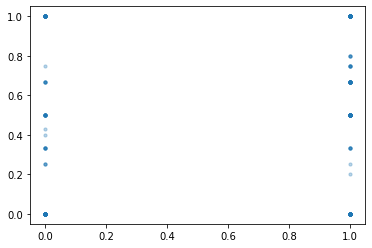

Pearson correlation:  (0.6337425493184892, 1.6895155125640227e-71)
Spearman correlation:  SpearmanrResult(correlation=0.621828247990028, pvalue=3.770684380635237e-68)


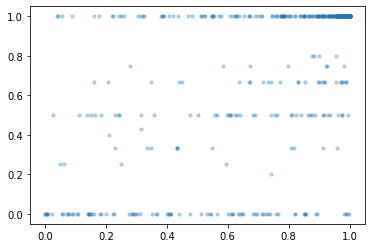

In [18]:
fields = ["species", "place"]

image_data = [
    json.loads(line)
    for line in open(
        "/pasteur/u/yuhuiz/data/Waterbird/processed_attribute_dataset/attributes.jsonl"
    )
]

def filter_fn(x):
    return x["attributes"]["split"] == "val"

image_data = [x for x in image_data if filter_fn(x)]

def label_fn(x):
    return x["attributes"]["waterbird"]

for item in image_data:
    item["label"] = label_fn(item)

image_dataset = ImageDataset(data=image_data)
image_dataloader = create_dataloader(
    dataset=image_dataset, modality="image", transform=transform
)
image_metrics = run_one_epoch(
    dataloader=image_dataloader,
    model=model,
    clip_model=clip_model,
    modality="image",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)
image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
image_subgroups = subgrouping(image_data, fields)
image_subgroup_metrics = computing_subgroup_metrics(
    image_preds, image_labels, image_subgroups
)
pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1])[:10])
pprint("\n")

attributes = {
    "place": set([x["attributes"]["place"] for x in image_data]),
    "species": set([x["attributes"]["species"] for x in image_data]),
}
attributes_combinations = [
    dict(zip(attributes, x)) for x in itertools.product(*attributes.values())
]
species_to_label = {
    x["attributes"]["species"]: x["attributes"]["waterbird"] for x in image_data
}
places_to_label = {
    x["attributes"]["place"]: x["attributes"]["waterplace"] for x in image_data
}
text_data = [
    {
        "text": f"a photo of a {x['species']} in the {x['place']}.",
        "label": species_to_label[x["species"]],
        "attributes": {
            "waterbird": species_to_label[x["species"]],
            "waterplace": places_to_label[x["place"]],
            "species": x["species"],
            "place": x["place"],
        },
    }
    for x in attributes_combinations
]
text_dataset = TextDataset(data=text_data)
text_dataloader = create_dataloader(dataset=text_dataset, modality="text")
text_metrics = run_one_epoch(
    dataloader=text_dataloader,
    model=model,
    clip_model=clip_model,
    modality="text",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)
text_preds, text_labels = text_metrics["preds"], text_metrics["labels"]
text_subgroups = subgrouping(text_data, fields)
text_subgroup_metrics = computing_subgroup_metrics(
    text_preds, text_labels, text_subgroups
)
pprint(sorted(text_subgroup_metrics.items(), key=lambda x: x[1])[:10])
pprint("\n")


# compute pearson and spearman correlation between image_subgroup_metrics and text_subgroup_metrics
accs = [(text_subgroup_metrics[x], image_subgroup_metrics[x]) for x in image_subgroup_metrics]
accs = np.array(accs)
print("Pearson correlation: ", pearsonr(accs[:, 0], accs[:, 1]))
print("Spearman correlation: ", spearmanr(accs[:, 0], accs[:, 1]))
plt.scatter(accs[:, 0], accs[:, 1], alpha=0.3, s=10)
plt.show()
###################################################################### probs ######################################################################

text_logits = text_metrics["logits"]
text_probs = torch.softmax(torch.tensor(text_logits), dim=1).numpy().tolist()
text_subgroup_probs = {(("species", x["attributes"]["species"]), ("place", x["attributes"]["place"])): text_probs[i][x["attributes"]["waterbird"]] for i, x in enumerate(text_data)}
probs = [(text_subgroup_probs[x], image_subgroup_metrics[x]) for x in image_subgroup_metrics]
probs = np.array(probs)
print("Pearson correlation: ", pearsonr(probs[:, 0], probs[:, 1]))
print("Spearman correlation: ", spearmanr(probs[:, 0], probs[:, 1]))
plt.scatter(probs[:, 0], probs[:, 1], alpha=0.3, s=10)
plt.show()

# Attribute-based Interpretation

In [2]:
image_data = [
    json.loads(line)
    for line in open(
        "/pasteur/u/yuhuiz/data/Waterbird/processed_attribute_dataset/attributes.jsonl"
    )
]

def filter_fn(x):
    return x["attributes"]["split"] == "val"

image_data = [x for x in image_data if filter_fn(x)]

attributes = {
    "place": set([x["attributes"]["place"] for x in image_data]),
    "species": set([x["attributes"]["species"] for x in image_data]),
}

clip_model, transform = clip.load(name=CLIP_MODEL, device="cuda")
clip_model = clip_model.float().eval()
model = Linear(clip_model.visual.output_dim, 2).cuda().eval()
state_dict = torch.load("waterbird_linear_model.pt")
model.load_state_dict(state_dict)

<All keys matched successfully>

## Direct inflence

In [3]:
attribute_list = list(attributes["place"])
print(attribute_list)

attribute_embeddings = F.normalize(clip_model.encode_text(clip.tokenize(attribute_list).cuda()))
probs = torch.softmax(model(attribute_embeddings), dim=1)

print("If we care about waterbird (label = 1), the most similar attributes are:")
print(sorted(zip(attribute_list, probs[:, 1].tolist()), key=lambda x: x[1], reverse=True))

['bamboo forest', 'lake natural', 'ocean', 'forest broadleaf']
If we care about waterbird (label = 1), the most similar attributes are:
[('ocean', 0.5517702102661133), ('lake natural', 0.5469737648963928), ('forest broadleaf', 0.3656281530857086), ('bamboo forest', 0.3377529978752136)]


## Aggregated Influence: Shapley Value s(a) = E_{S subset {F \ a}} [f(S, a) - f(S)]

In [6]:
place_list = list(attributes["place"])
species_list = list(attributes["species"])

for place in place_list:
    prompts = [f"a photo of a {species}." for species in species_list] + [f"a photo of a {species} in the {place}." for species in species_list]
    with torch.no_grad():
        inputs = clip.tokenize(prompts).cuda()
        embeddings = F.normalize(clip_model.encode_text(inputs))
        probs = torch.softmax(model(embeddings), dim=1).cpu()

    print(f"Shapley value of {place} for waterbird = {(probs[len(species_list):, 1] - probs[:len(species_list), 1]).mean()}")

Shapley value of ocean for waterbird = 0.1020495817065239
Shapley value of lake natural for waterbird = 0.03814540058374405
Shapley value of bamboo forest for waterbird = -0.10287292301654816
Shapley value of forest broadleaf for waterbird = -0.087743379175663
